In [1]:
import os
from time import time
import pandas as pd
import numpy as np
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.utils.extmath import density
from sklearn import svm
from sklearn import naive_bayes
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.utils import shuffle


np.random.seed(42)

In [2]:
#comment_file = 'C:/Users/zhang/Untitled Folder/stock_comments_seg.csv'
data_path = 'C:/Users/zhang/Untitled Folder'
pos_corpus = 'positive.txt'
neg_corpus = 'negative.txt'
K_Best_Features = 3000

def load_dataset():
    pos_file = os.path.join(data_path, pos_corpus)
    neg_file = os.path.join(data_path, neg_corpus)

    pos_sents = []
    with open(pos_file, 'r', encoding='utf-8') as f:
        for sent in f:
            pos_sents.append(sent.replace('\n', ''))

    neg_sents = []
    with open(neg_file, 'r', encoding='utf-8') as f:
        for sent in f:
            neg_sents.append(sent.replace('\n', ''))

    balance_len = min(len(pos_sents), len(neg_sents))

    pos_df = pd.DataFrame(pos_sents, columns=['text'])
    pos_df['polarity'] = 1
    pos_df = pos_df[:balance_len]

    neg_df = pd.DataFrame(neg_sents, columns=['text'])
    neg_df['polarity'] = 0
    neg_df = neg_df[:balance_len]

    return pd.concat([pos_df, neg_df]).reset_index(drop=True)
#    return pd.concat([pos_df, neg_df]).sample(frac=1).reset_index(drop=True)

def load_dataset_tokenized():
    pos_file = os.path.join(data_path, pos_corpus)
    neg_file = os.path.join(data_path, neg_corpus)

    pos_sents = []
    with open(pos_file, 'r', encoding='utf-8') as f:
        for line in f:
            tokens = line.split(' ')
            sent = []
            for t in tokens:
                if t.strip():
                    sent.append(t.strip())
            pos_sents.append(sent)

    neg_sents = []
    with open(neg_file, 'r', encoding='utf-8') as f:
        for line in f:
            tokens = line.split(' ')
            sent = []
            for t in tokens:
                if t.strip():
                    sent.append(t.strip())
            neg_sents.append(sent)

    balance_len = min(len(pos_sents), len(neg_sents))

    texts = pos_sents + neg_sents
    labels = [1] * balance_len + [0] * balance_len

    return texts, labels


def KFold_validation(clf, X, y):
    acc = []
    pos_precision, pos_recall, pos_f1_score = [], [], []
    neg_precision, neg_recall, neg_f1_score = [], [], []

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    for train, test in kf.split(X):
        X_train = [X[i] for i in train]
        X_test = [X[i] for i in test]
        y_train = [y[i] for i in train]
        y_test = [y[i] for i in test]

        # vectorizer = TfidfVectorizer(analyzer='word', tokenizer=lambda x : (w for w in x.split(' ') if w.strip()))
        def dummy_fun(doc):
            return doc

        vectorizer = TfidfVectorizer(analyzer='word',
                                     tokenizer=dummy_fun,
                                     preprocessor=dummy_fun,
                                     token_pattern=None)

        vectorizer.fit(X_train)
        X_train = vectorizer.transform(X_train)
        X_test = vectorizer.transform(X_test)

        clf.fit(X_train, y_train)
        preds = clf.predict(X_test)

        acc.append(metrics.accuracy_score(y_test, preds))
        pos_precision.append(metrics.precision_score(y_test, preds, pos_label=1))
        pos_recall.append(metrics.recall_score(y_test, preds, pos_label=1))
        pos_f1_score.append(metrics.f1_score(y_test, preds, pos_label=1))
        neg_precision.append(metrics.precision_score(y_test, preds, pos_label=0))
        neg_recall.append(metrics.recall_score(y_test, preds, pos_label=0))
        neg_f1_score.append(metrics.f1_score(y_test, preds, pos_label=0))


    return (np.mean(acc), np.mean(pos_precision), np.mean(pos_recall), np.mean(pos_f1_score),
            np.mean(neg_precision), np.mean(neg_recall), np.mean(neg_f1_score))


def benchmark_clfs():
    print('Loading dataset...')

    X, y = load_dataset_tokenized()

    classifiers = [
        ('LinearSVC', svm.LinearSVC()),
        ('LogisticReg', LogisticRegression()),
        ('SGD', SGDClassifier()),
        ('MultinomialNB', naive_bayes.MultinomialNB()),
        ('KNN', KNeighborsClassifier()),
        ('DecisionTree', DecisionTreeClassifier()),
        ('RandomForest', RandomForestClassifier()),
        ('AdaBoost', AdaBoostClassifier(base_estimator=LogisticRegression()))
    ]

    cols = ['metrics', 'accuracy',  'pos_precision', 'pos_recall', 'pos_f1_score', 'neg_precision', 'neg_recall', 'neg_f1_score']
    scores = []
    for name, clf in classifiers:
        score = KFold_validation(clf, X, y)
        row = [name]
        row.extend(score)
        scores.append(row)

    df = pd.DataFrame(scores, columns=cols).T
    df.columns = df.iloc[0]
    df.drop(df.index[[0]], inplace=True)
    df = df.apply(pd.to_numeric, errors='ignore')

    return df

def dummy_fun(doc):
        return doc

In [3]:
X, y = load_dataset_tokenized()
clf = svm.LinearSVC()

vectorizer = TfidfVectorizer(analyzer='word',
                                 tokenizer=dummy_fun,
                                 preprocessor=dummy_fun,
                                 token_pattern=None)

X = vectorizer.fit_transform(X)

print('Train model...')
clf.fit(X, y)
print('Loading comments...')

Train model...
Loading comments...


In [4]:
#initialize
comment_file='D:/股吧评论/gu000002.xlsx'
id='000002'

df = pd.read_excel(comment_file)
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

#df['created_time'] = pd.to_datetime(df['created_time'], format='%Y-%m-%d %H:%M:%S')

df['created_time'] = pd.to_datetime(df['Date'], format='%Y-%m-%d %H:%M',errors='coerce')
df['created_time'] = df['created_time'].dt.strftime('%Y-%m-%d')
df['polarity'] = 0
#df['title'].apply(lambda x: [w.strip() for w in x.split()])

In [7]:
df = df[df['title']!=0]


#df=df.loc[0:20000,]
df = df[df['title']!=0]# after debug i found there are 127 title which is interge 0, so delete this lines
texts = df['title']


texts = vectorizer.transform(texts)

preds = clf.predict(texts)
df['polarity'] = preds

#df.to_csv('000002_comments_analyzed.csv', index=False)


#if __name__ == '__main__':
 #   scores = benchmark_clfs()
  #  print(scores)
   # scores.to_csv('model_ml_scores.csv', float_format='%.4f')


    

In [14]:
#compute score

import tushare as ts
pro = ts.pro_api()#need to initialize token first: refer https://tushare.pro/document/1?doc_id=40

start_date='2008-01-01'

grouped = df['polarity'].groupby(df.created_time)#.dt.date)


def BI_Simple_func(row):
    pos = row[row == 1].count()
    neg = row[row == 0].count()

    return (pos-neg)/(pos+neg)

BI_Simple_index = grouped.apply(BI_Simple_func)


def BI_func(row):
    pos = row[row == 1].count()
    neg = row[row == 0].count()

    bi = np.log(1.0 * (1+pos) / (1+neg))

    return bi


BI_index = grouped.apply(BI_func)

sentiment_idx = pd.concat([BI_index.rename('BI'), BI_Simple_index.rename('BI_Simple')], axis=1)
if int(id)>100000:
    stock_code=id+'.SH'
else:
    stock_code=id+'.SZ'
quotes = pro.daily(ts_code=stock_code, start_date=start_date)
quotes.set_index('trade_date', inplace=True)
pct_chg=quotes['pct_chg'].shift(periods=1, fill_value=0)
sentiment_idx.index = pd.to_datetime(sentiment_idx.index)
merged = pd.merge(sentiment_idx, pct_chg, how='right', left_index=True, right_index=True)

merged = merged.dropna(axis=0)
merged['BI_MA'] = merged['BI'].rolling(window=10, center=False).mean()
merged['BI_Simple_MA'] = merged['BI_Simple'].rolling(window=10, center=False).mean()

In [20]:
 m = pd.merge(merged,quotes['close'], how='inner', left_index=True, right_index=True)

Text(0, 0.5, 'Density')

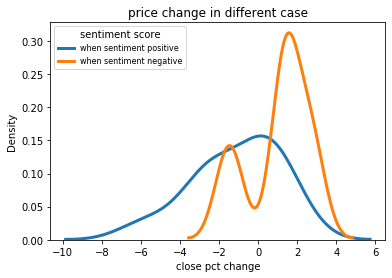

In [18]:
#plot boxplot
import seaborn as sns
import matplotlib.pyplot as plt
a = merged[merged['BI_Simple']>0.75]['pct_chg']
b = merged[merged['BI_Simple']<-0.75]['pct_chg']
sns.distplot(a, hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = 'when sentiment positive')
sns.distplot(b, hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = 'when sentiment negative')
plt.legend(prop={'size': 8}, title = 'sentiment score')
plt.title('price change in different case')
plt.xlabel('close pct change')
plt.ylabel('Density')

In [22]:
m.to_csv('000002.csv')

In [19]:
merged.corr()

,BI,BI_Simple,pct_chg,BI_MA,BI_Simple_MA
BI,1.000000,0.992583,-0.020861,0.449093,0.450178
BI_Simple,0.992583,1.000000,-0.022576,0.441271,0.444472
pct_chg,-0.020861,-0.022576,1.000000,-0.010202,-0.011016
BI_MA,0.449093,0.441271,-0.010202,1.000000,0.997431
BI_Simple_MA,0.450178,0.444472,-0.011016,0.997431,1.000000


In [ ]:
#plot
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
#figure(figsize=(100,1))
fig, ax1 = plt.subplots()
fig.set_size_inches(21, 5.5)
ax2 = ax1.twinx()
ax1.plot(merged.index, merged['BI_MA'], color='#1F77B4', linestyle=':',label='today BI_index')
ax1.axhline(y=0,linestyle='-')
ax2.plot(merged.index, merged['pct_chg'], color='#4B73B1',label='tomorrows pct_change')
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)
ax1.set_xlabel('date')
ax1.set_ylabel('BI_index')
ax2.set_ylabel('pct_chg')
plt.savefig("C:/Users/zhang/Pictures/"+id)
plt.show()

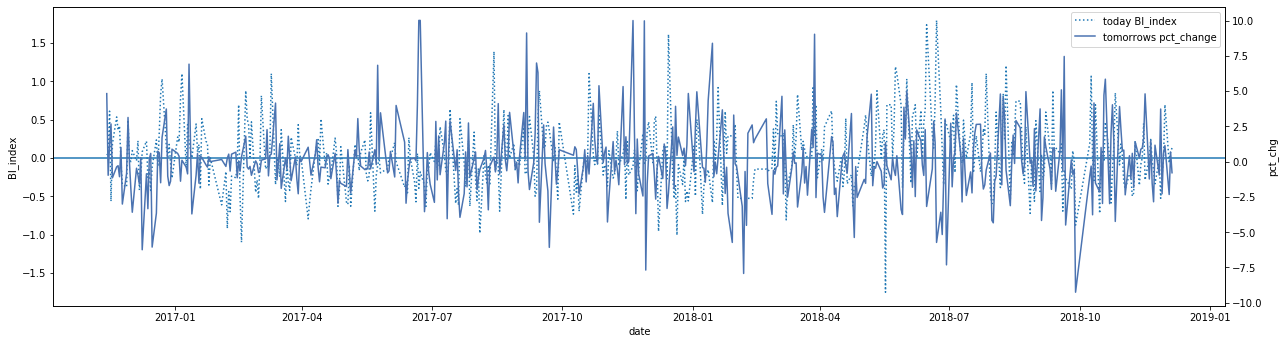

In [249]:
a = merged['BI'][300:800]
b = merged['pct_chg'][300:800]
fig, ax1 = plt.subplots()
fig.set_size_inches(21, 5.5)
ax2 = ax1.twinx()
ax1.plot(a.index, a, color='#1F77B4', linestyle=':',label='today BI_index')
ax1.axhline(y=0,linestyle='-')
ax2.plot(b.index,b, color='#4B73B1',label='tomorrows pct_change')
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)
ax1.set_xlabel('date')
ax1.set_ylabel('BI_index')
ax2.set_ylabel('pct_chg')
#plt.savefig("C:/Users/zhang/Pictures/"+id)
plt.show()


In [23]:
m

,BI,BI_Simple,pct_chg,BI_MA,BI_Simple_MA,close
trade_date,,,,,,
2020-02-20,1.386294,1.000000,-2.0101,NaN,NaN,29.85
2019-07-17,0.693147,1.000000,-0.1328,NaN,NaN,30.13
2019-02-20,-0.275412,-0.139785,-2.4611,NaN,NaN,27.63
2019-02-19,0.161268,0.082353,2.2198,NaN,NaN,27.03
2019-02-18,-0.127155,-0.064516,-0.6250,NaN,NaN,27.20
...,...,...,...,...,...,...
2008-01-09,0.176456,0.089431,1.2300,-0.101820,-0.050654,30.18
2008-01-08,0.175891,0.088235,1.0000,-0.067525,-0.033465,29.88
2008-01-07,-0.103720,-0.052083,-0.9900,-0.073549,-0.036490,30.18


Text(0, 0.5, 'Density')

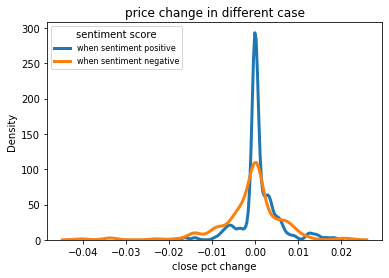

In [318]:
df = pd.read_csv('Untitled Folder/merged_sentiment_idx.csv', parse_dates=['created_time'])#Untitled Folder/merged_sentiment_idx.csv
df['close']=df['close'].pct_change().shift(periods=1,fill_value=0)
a = df[df['BI_Simple']>np.mean(df['BI_Simple'])]['close']
b = df[df['BI_Simple']<np.mean(df['BI_Simple'])]['close']
sns.distplot(a, hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = 'when sentiment positive')
sns.distplot(b, hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = 'when sentiment negative')
plt.legend(prop={'size': 8}, title = 'sentiment score')
plt.title('price change in different case')
plt.xlabel('close pct change')
plt.ylabel('Density')

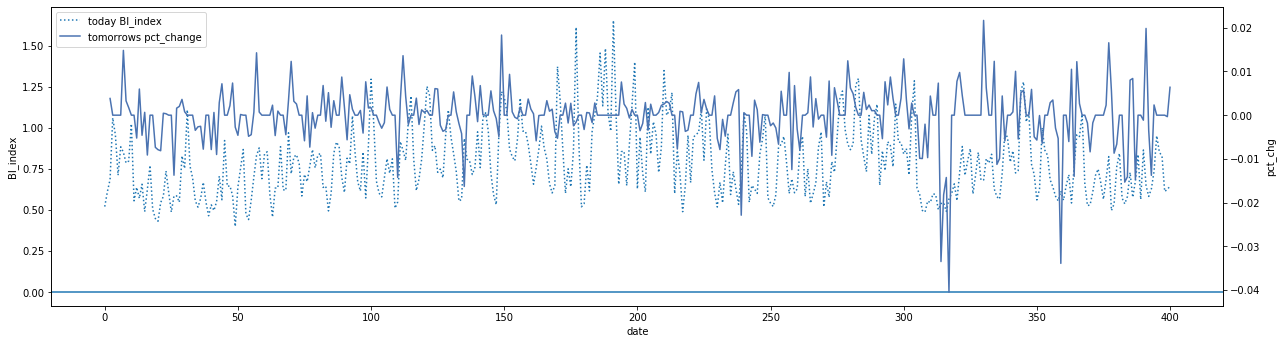

In [282]:
fig, ax1 = plt.subplots()
fig.set_size_inches(21, 5.5)
ax2 = ax1.twinx()
ax1.plot(df.index, df['BI'], color='#1F77B4', linestyle=':',label='today BI_index')
ax1.axhline(y=0,linestyle='-')
ax2.plot(df.index,df['close'], color='#4B73B1',label='tomorrows pct_change')
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)
ax1.set_xlabel('date')
ax1.set_ylabel('BI_index')
ax2.set_ylabel('pct_chg')
#plt.savefig("C:/Users/zhang/Pictures/"+id)
plt.show()

In [299]:
m=merged

Text(0, 0.5, 'Density')

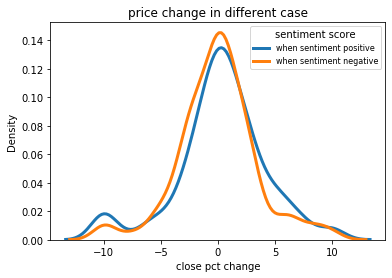

In [317]:
#plot boxplot
import seaborn as sns
a = merged[merged['BI_Simple']>np.mean(merged['BI_Simple'])]['pct_chg']
b = merged[merged['BI_Simple']<np.mean(merged['BI_Simple'])]['pct_chg']
sns.distplot(a, hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = 'when sentiment positive')
sns.distplot(b, hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = 'when sentiment negative')
plt.legend(prop={'size': 8}, title = 'sentiment score')
plt.title('price change in different case')
plt.xlabel('close pct change')
plt.ylabel('Density')

In [316]:
np.mean(merged['BI_Simple'])

-0.08815325098677641

In [314]:
merged.corr()

,BI,BI_Simple,pct_chg,BI_MA,BI_Simple_MA
BI,1.000000,0.978006,0.021004,0.437867,0.437599
BI_Simple,0.978006,1.000000,0.010736,0.424983,0.425771
pct_chg,0.021004,0.010736,1.000000,-0.066101,-0.060894
BI_MA,0.437867,0.424983,-0.066101,1.000000,0.996021
BI_Simple_MA,0.437599,0.425771,-0.060894,0.996021,1.000000


In [321]:
train_set=load_dataset()

In [335]:
train_set.to_csv('train_set.txt',sep='\t',header=False,index=False)


In [334]:
train_set

,text,polarity
0,买入 长期 持有 沃森 生物 19条 简短 想法,1
1,利好 出 还 涨,1
2,线 战士 持 全安 牌 伟哥 火爆 进货 深交所 9月 17日 暂停 etf 融资 买入 e...,1
3,浙江 冬日 彻底 破位,1
4,达安 基因 该涨,1
...,...,...
9209,小票 人 今天 都 不爽,0
9210,更 垃圾,0
9211,海王利好 不涨 庄家 耗着 情况 不 妙要 暴跌,0
9212,庄稼 拼命 出货,0
